In [2]:
import numpy as np
from numba import njit,prange
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
from skimage.exposure import histogram
from matplotlib.pyplot import bar
from skimage.color import rgb2gray,rgb2hsv
from skimage import data


In [3]:
def medianFilter(img):
    h,w = img.shape
    my_out_img = np.zeros((h,w),dtype=np.uint8)

    for x in range(h):
        for y in range(w):
            # we need to specify the window and take its median
            my_out_img[x,y] = np.median(img[max(x-1,0):min(x+2,h-1),max(0,y-1):min(y+2,w-1)],axis=None)
    return my_out_img


In [4]:


@njit
def padding(img,pad):
    padded_img = np.zeros((img.shape[0]+2*pad,img.shape[1]+2*pad))
    padded_img[pad:-pad,pad:-pad] = img
    return padded_img

@njit()
def AdaptiveMedianFilter(img,s=3,sMax=7):
    if len(img.shape) == 3:
        raise Exception ("Single channel image only")

    H,W = img.shape
    a = sMax//2
    padded_img = padding(img,a)

    f_img = np.zeros(padded_img.shape)

    for i in prange(a,H+a+1):
        for j in range(a,W+a+1):
            value = Lvl_A(padded_img,i,j,s,sMax)
            f_img[i,j] = value

    return f_img[a:-a,a:-a] 

@njit
def Lvl_A(mat,x,y,s,sMax):
    window = mat[x-(s//2):x+(s//2)+1,y-(s//2):y+(s//2)+1]
    Zmin = np.min(window)
    Zmed = np.median(window)
    Zmax = np.max(window)

    A1 = Zmed - Zmin
    A2 = Zmed - Zmax

    if A1 > 0 and A2 < 0:
        # the median is an intermediate value and we may find a peak
        return Lvl_B(window, Zmin, Zmed, Zmax)
    else:
        # the median is a peak => search for in a new window 
        s += 2 
        if s <= sMax:
            return Lvl_A(mat,x,y,s,sMax)
        else:
             return Zmed

@njit
def Lvl_B(window, Zmin, Zmed, Zmax):
    h,w = window.shape

    Zxy = window[h//2,w//2]
    B1 = Zxy - Zmin
    B2 = Zxy - Zmax
    # Zxy> Zmin and Zxy < Zmax 
    if B1 > 0 and B2 < 0 :
        return Zxy
    else:
        return Zmed
    
    
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 



(512, 512)


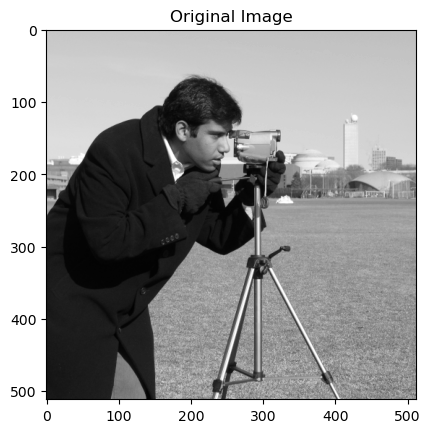

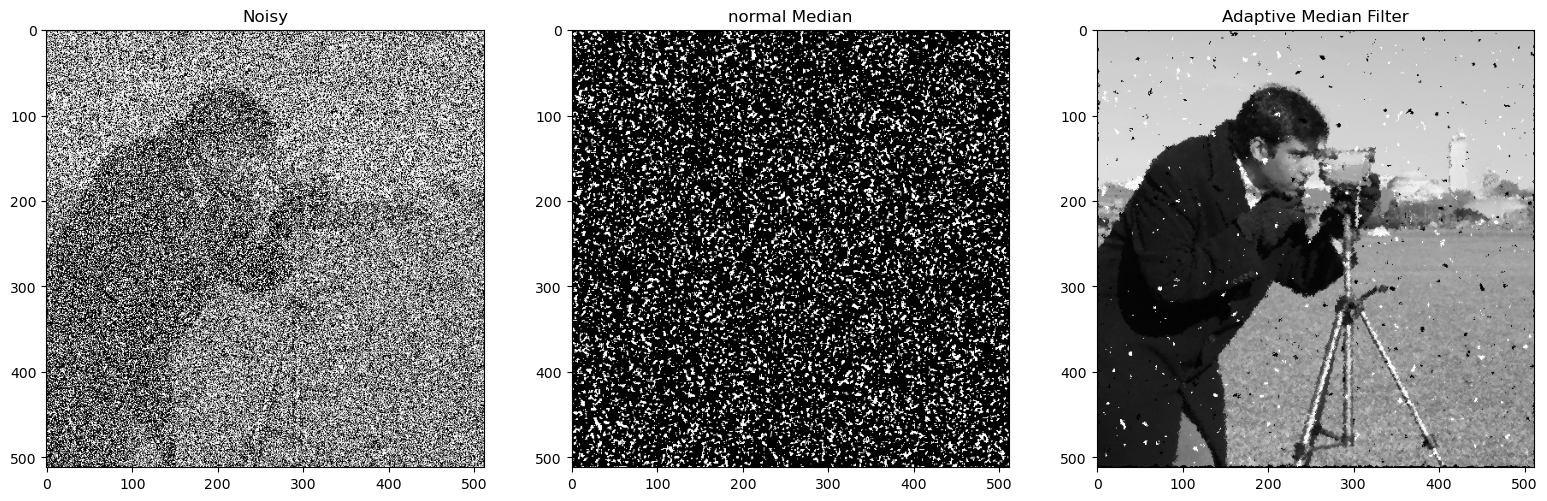

In [5]:
from skimage.util import random_noise


img = data.camera()
print(img.shape)
show_images([img],["Original Image"])
img = random_noise(img,mode='s&p',amount = 0.7)
show_images([img,medianFilter(img),AdaptiveMedianFilter(img)],['Noisy','normal Median',"Adaptive Median Filter"])


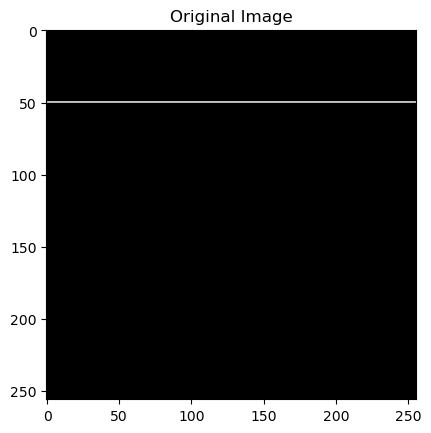

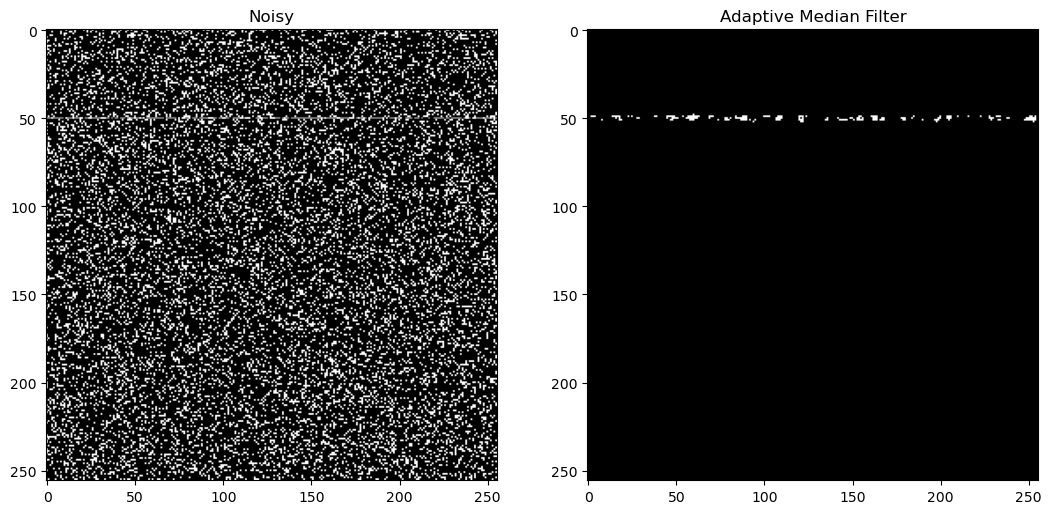

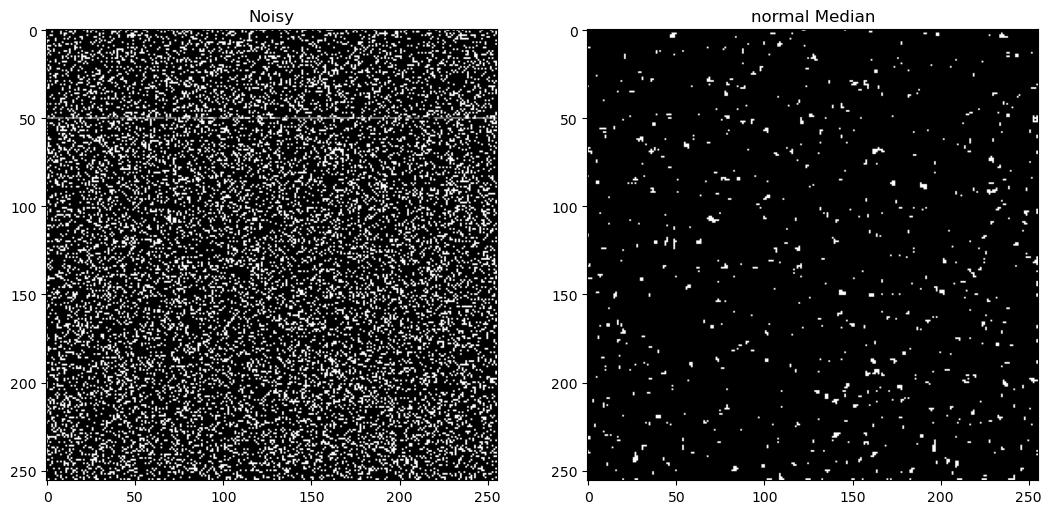

In [6]:
# create an image with one line in the middle
img = np.zeros((256,256))   
img[50,:] = 0.5
show_images([img],["Original Image"])
img = random_noise(img,mode='s&p',amount = 0.4)
show_images([img,AdaptiveMedianFilter(img)],['Noisy',"Adaptive Median Filter"])
show_images([img,medianFilter(img)],['Noisy',"normal Median"])

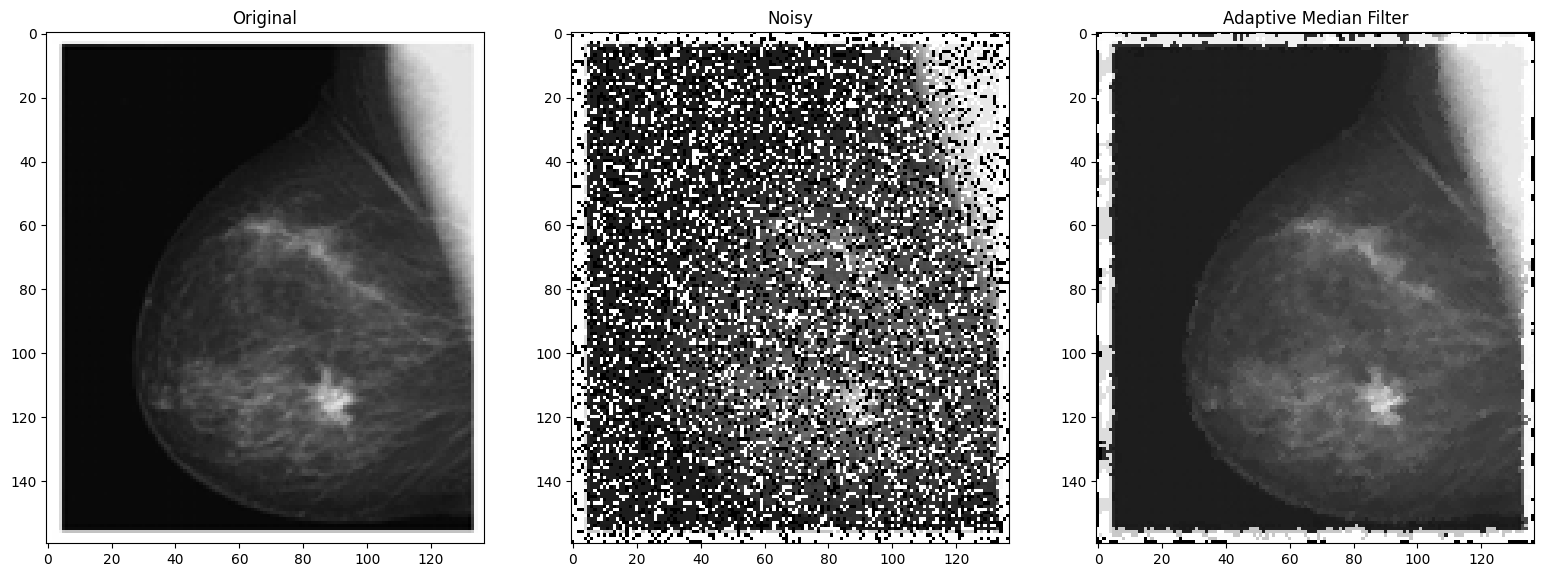

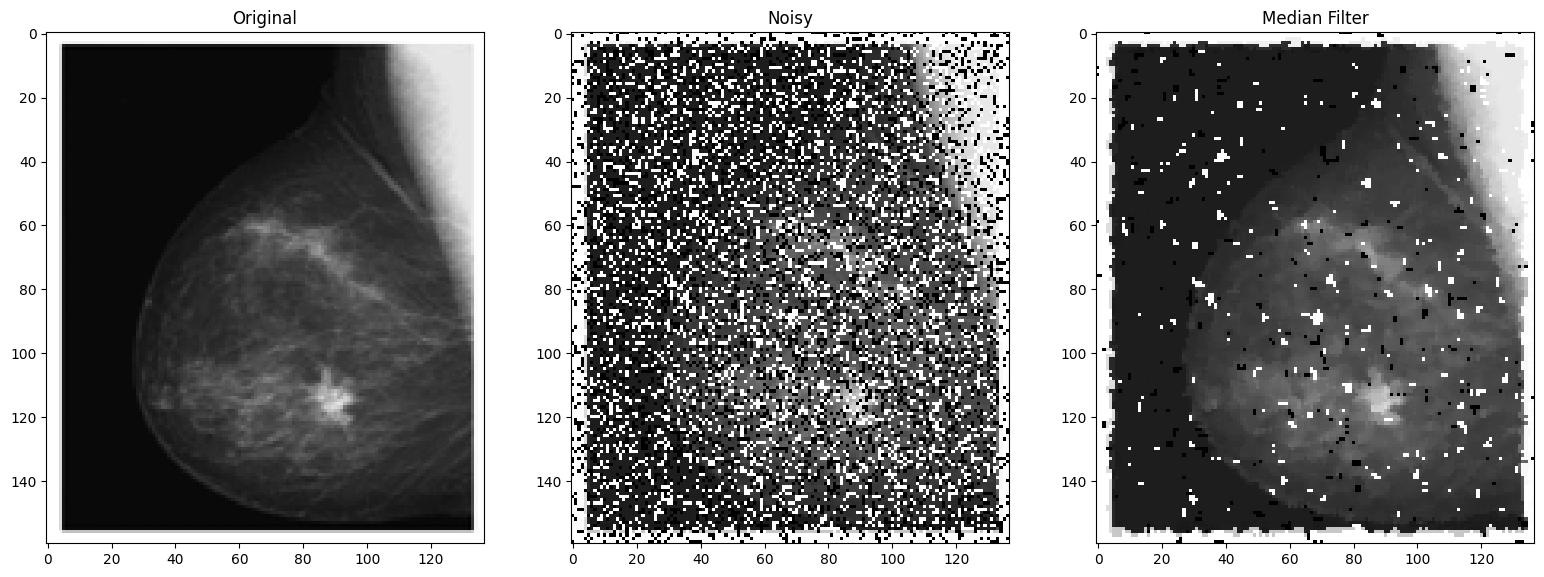

In [19]:
from skimage.filters import median 
img = io.imread("./Picture1.png", as_gray=True)

noisy_img = random_noise(img,mode='s&p',amount = 0.4)

show_images([img,noisy_img,AdaptiveMedianFilter(noisy_img)],['Original',"Noisy","Adaptive Median Filter"])

median_img = median(noisy_img)
show_images([img,noisy_img,median_img],['Original',"Noisy","Median Filter"])